In [1]:
import sklearn.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np

In [2]:
X, Y = datasets.load_iris(return_X_y=True)

In [3]:
import sklearn.decomposition as decomposition
import sklearn.preprocessing as preprocessing
from sklearn.metrics import accuracy_score

In [4]:
def calc_zz(mod, xr, yr):
    xrange = np.linspace(xr[0], xr[1], 101)
    yrange = np.linspace(yr[0], yr[1], 101)
    XX, YY = np.meshgrid(xrange, yrange)
    XY = np.c_[XX.ravel(), YY.ravel()]
    ZZ = mod.evaluate_all(XY)
    ZZ = ZZ.reshape(XX.shape)
    return ZZ

In [5]:
def plot_params(mod, ax=None):
    if ax is None:
        ax = plt.gca()
    ymax = np.asarray(mod.param.base[1:].copy())
    ymin = np.asarray(mod.param.base[1:].copy())
    np.putmask(ymax, ymax<0, 0)
    np.putmask(ymin, ymax>0, 0)
    n = len(ymin)
    print(n)
    ax.vlines(range(n), ymin, ymax, color='k', linewidth=1., label=r"Вектор коэффициентов $\mathbf{w}$")
    ax.minorticks_on()
    ax.set_ylabel(r"$w_k$")
    ax.legend(loc="upper right")


In [6]:
pca = decomposition.PCA()
pca.fit(X)

PCA()

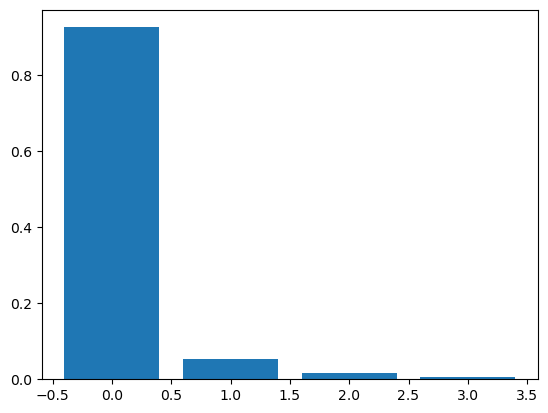

In [7]:
plt.bar(range(4), pca.explained_variance_ratio_)
plt.show()

In [8]:
U = pca.transform(X)
U = U[:,:2]

In [9]:
U2 = U[Y != 0]
Y2 = Y[Y != 0]
np.putmask(Y2, Y2 == 1, -1)
np.putmask(Y2, Y2 == 2, +1)
Y2 = Y2.astype('d')

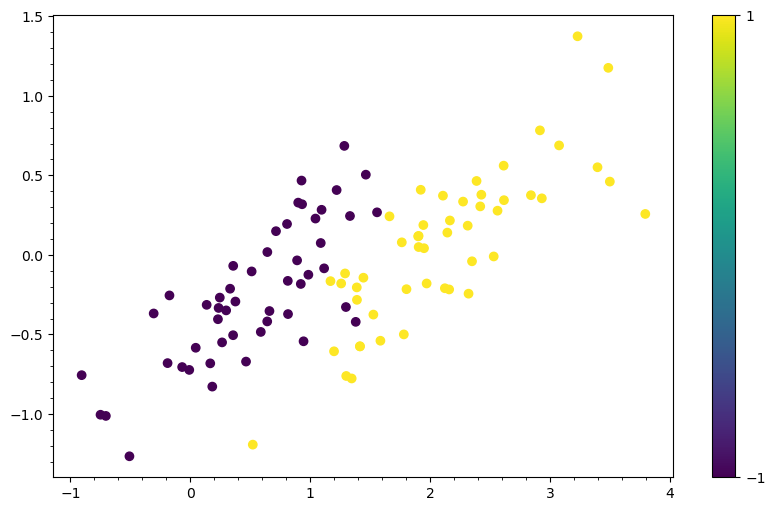

In [10]:
plt.figure(figsize=(10,6))
sc = plt.scatter(U2[:,0], U2[:,1], c=Y2)
plt.colorbar(sc,ticks=[-1,+1])
plt.minorticks_on()
plt.show()

In [125]:
import mlgrad.loss as loss
import mlgrad.funcs as funcs
import mlgrad.models as models
import mlgrad.funcs2 as funcs2
import mlgrad.gd as gd
import mlgrad.regr as regr
import mlgrad.inventory as inventory
import mlgrad.plots as plots

In [12]:
hinge_loss = loss.MarginLoss(funcs.Hinge(1))
l2_reg = funcs2.SquareNorm()
l1_reg = funcs2.AbsoluteNorm()
sigmoidal_func = funcs.Sigmoidal(2.0)
sq_loss = loss.ErrorLoss(funcs.Square())

In [13]:
mod = models.SigmaNeuronModel(funcs.Sigmoidal(10.0), 2)

In [14]:
alg = regr.regression(U2, Y2, mod, 
                        loss_func=sq_loss, 
                        # lossfunc=hinge_loss, 
                        h=0.01, n_iter=1000)
print("Accuracy score:", accuracy_score(np.sign(mod.evaluate_all(U2)), Y2))

Accuracy score: 0.96


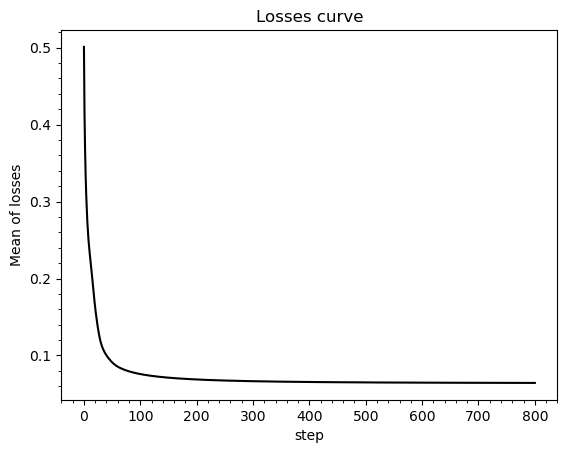

In [15]:
plots.plot_losses(alg)

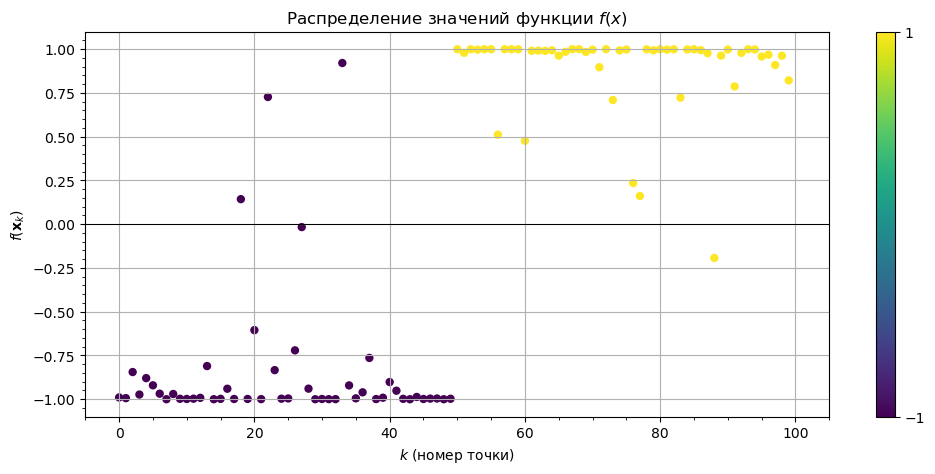

In [16]:
plt.figure(figsize=(12,5))
plots.plot_cls_function(mod, U2, Y2)
plt.show()

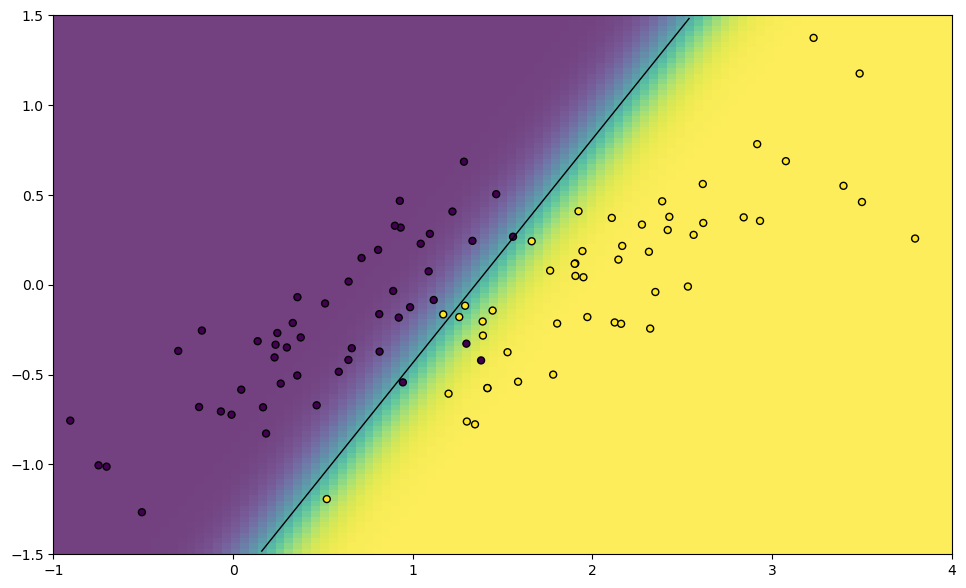

In [17]:
ZZ = calc_zz(mod, [-1.,4.], [-1.5,1.5])
plt.figure(figsize=(12,7))
cs = plt.scatter(U2[:,0], U2[:,1], c=Y2, edgecolors='k', s=25)
plt.imshow(ZZ, origin='lower', extent=(-1., 4,-1.5, 1.5), alpha=0.75)
# plt.colorbar(cs, ticks=[-1,0,1])
plt.contour(ZZ, levels=[0], origin='lower', extent=(-1.,4,-1.5, 1.5), linewidths=1, colors='k')
# plt.contour(ZZ, levels=[-0.1,0.1], origin='lower', extent=(-1.,4,-1.5, 1.5), linewidths=0.5, linestyles='--')
# plt.xlim(-2,2)
# plt.ylim(-2,2)
plt.show()

In [147]:
n_hidden = 50
body = models.FFNetworkModel()
linmod = models.LinearLayer(2, n_hidden) 
linmod.use_regularizer(l1_reg, 0.001)
body.add(linmod)

body.add(models.ScaleLayer(funcs.Sigmoidal(5.0), n_hidden))
head = models.LinearModel(body.n_output)
head.use_regularizer(l1_reg, 0.001)
nnmod = models.FFNetworkFuncModel(head, body)

In [148]:
nnmod.allocate()
nnmod.init_param()

In [149]:
alg = regr.regression(U2, Y2, nnmod,
                             loss_func=hinge_loss,
                             # loss_func=sq_loss,
                             # normalizer=gd.Masked(nnmod.n_param, 1.0e-5),
                             h=0.01, n_restart=2)
inventory.normalize(head.param)
accuracy_score(Y2, np.sign(nnmod.evaluate_all(U2)))

1.0

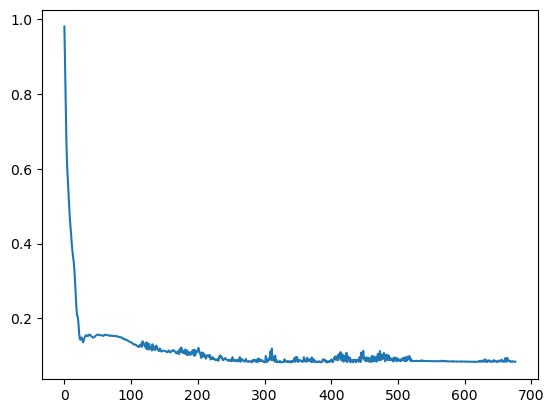

In [150]:
plt.plot(alg.lvals)
plt.show()

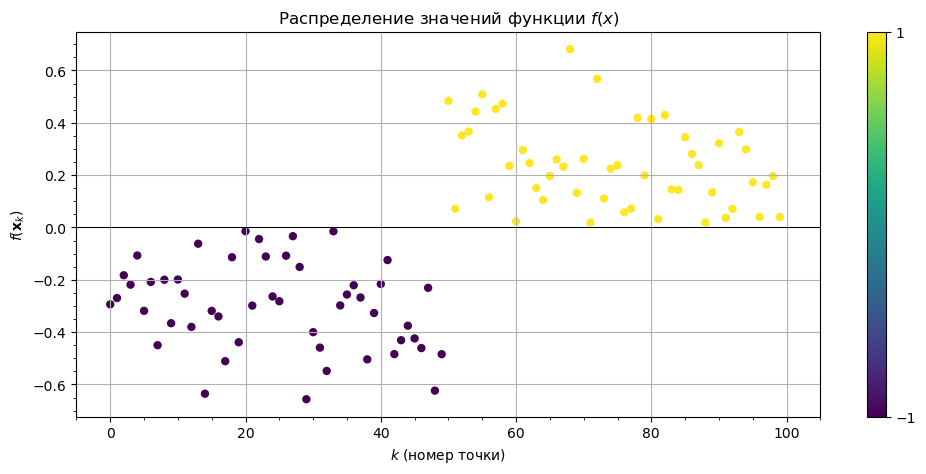

In [151]:
plt.figure(figsize=(12,5))
plots.plot_cls_function(nnmod, U2, Y2)
plt.show()

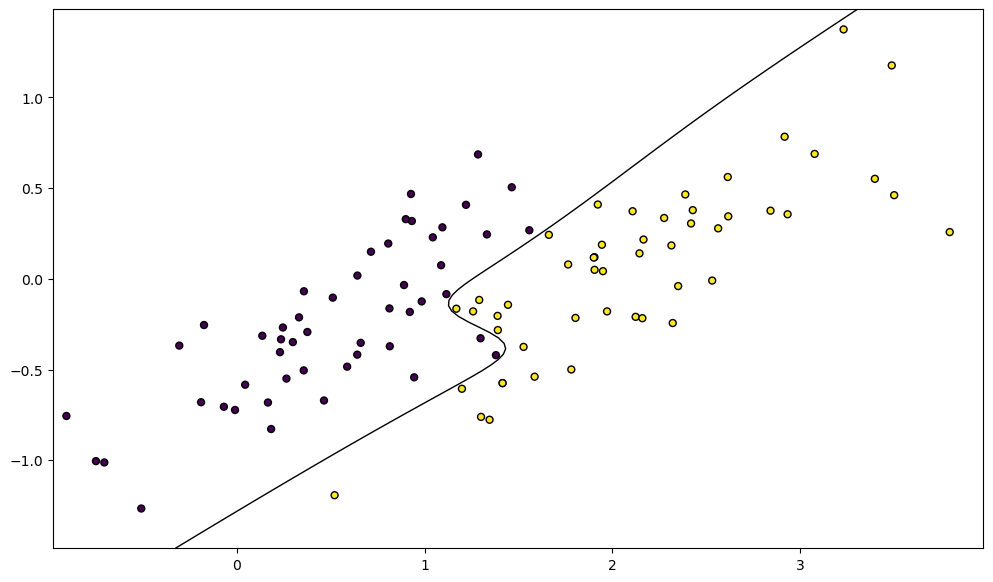

In [152]:
ZZ = calc_zz(nnmod, [-1.,4.], [-1.5,1.5])
plt.figure(figsize=(12,7))
cs = plt.scatter(U2[:,0], U2[:,1], c=Y2, edgecolors='k', s=25)
# plt.imshow(ZZ, origin='lower', extent=(-1., 4,-1.5, 1.5), alpha=0.75)
# plt.colorbar(cs, ticks=[-1,0,1])
plt.contour(ZZ, levels=[0], origin='lower', extent=(-1.,4,-1.5, 1.5), linewidths=1, colors='k')
# plt.contour(ZZ, levels=[-1,1], origin='lower', extent=(-1.,4,-1.5, 1.5), linewidths=0.5, linestyles='--')
# plt.xlim(-2,2)
# plt.ylim(-2,2)
plt.show()

200


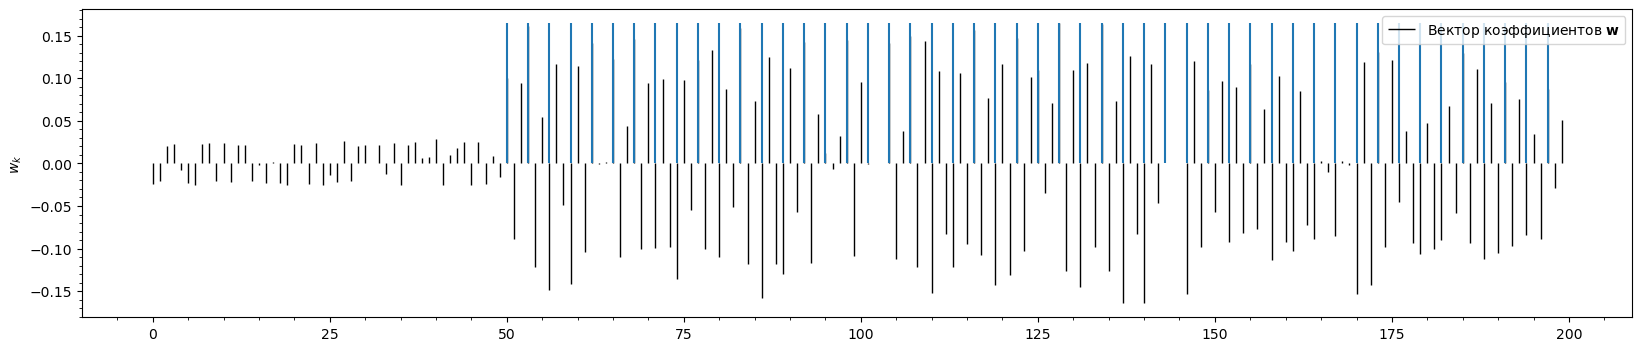

In [146]:
plt.figure(figsize=(20,4))
plot_params(nnmod)
plt.vlines([n_hidden+(U2.shape[1]+1)*i for i in range(n_hidden)], 0, np.max(nnmod.param))
plt.show()

400


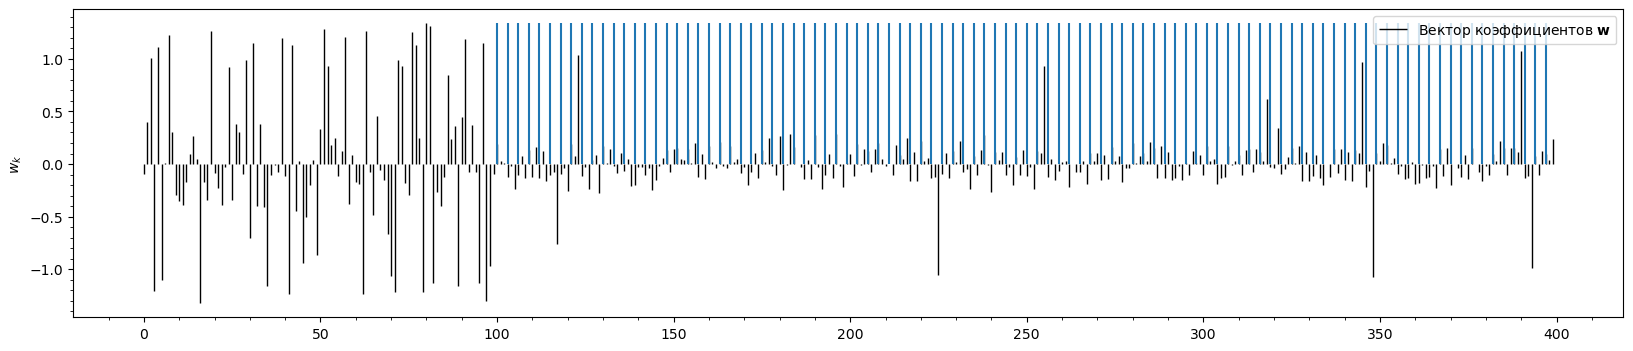

In [25]:
plt.figure(figsize=(20,4))
plot_params(nnmod)
plt.vlines([n_hidden+(U2.shape[1]+1)*i for i in range(n_hidden)], 0, np.max(nnmod.param))
plt.show()